# calc MLDfrom rho over NA - inst, week, month

In [1]:
#cluster
import dask
import datetime
import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
#from distributed.utils import tmpfile
#dask.config.set({"distributed.comm.timeouts.tcp": "50s"})

/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
!echo $HOSTNAME
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'compute' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "256GiB" # Max memory per node that is going to be used - this depends on the partition #for averaging max=256
cores = 16 # Max number of cores per task that are reserved - also partition dependend
processes = 16 #number of workers
walltime = '08:00:00' # Walltime - also partition dependent

l20303.atos.local


In [3]:
#calculate memory per worker and core
mem =256
memory_per_worker = mem/processes
memory_per_core = memory_per_worker/(cores/processes)
print('memory_per_worker =', memory_per_worker)
print('memory_per_core =', memory_per_core)

memory_per_worker = 16.0
memory_per_core = 16.0


In [4]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       processes=processes,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [5]:
dask_tmp_dir.name

'/scratch/m/m300878/PostProclvknnz_l'

In [6]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=16
#SBATCH --mem=256G
#SBATCH -t 08:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/m/m300878/PostProclvknnz_l
#SBATCH --begin=now
#SBATCH --output=/scratch/m/m300878/PostProclvknnz_l/LOG_cluster.%j.o

/home/m/m300878/miniconda3/envs/pyicon_py39/bin/python -m distributed.cli.dask_worker tcp://136.172.115.226:36541 --nthreads 1 --nprocs 16 --memory-limit 16.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/m/m300878/PostProclvknnz_l --interface ib0 --protocol tcp://



In [7]:
cluster.scale(jobs=2)
cluster

In [8]:
# try number 1 avoid spill to disk - seems not to arrive at client
dask.config.set({'distributed.worker.memory.spill': False})
dask.config.set({'distributed.worker.memory.target': False})

In [9]:
dask.config.get('distributed.worker')

{'blocked-handlers': [],
 'multiprocessing-method': 'spawn',
 'use-file-locking': True,
 'connections': {'outgoing': 50, 'incoming': 10},
 'preload': [],
 'preload-argv': [],
 'daemon': True,
 'validate': False,
 'resources': {},
 'lifetime': {'duration': None, 'stagger': '0 seconds', 'restart': False},
 'profile': {'interval': '10ms', 'cycle': '1000ms', 'low-level': False},
 'memory': {'recent-to-old-time': '30s',
  'rebalance': {'measure': 'optimistic',
   'sender-min': 0.3,
   'recipient-max': 0.6,
   'sender-recipient-gap': 0.1},
  'target': False,
  'spill': False,
  'pause': 0.8,
  'terminate': 0.95,
  'max-spill': False},
 'http': {'routes': ['distributed.http.worker.prometheus',
   'distributed.http.health',
   'distributed.http.statics']}}

In [11]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1147501   compute PostProc  m300878  R       0:15      1 l40150
           1147502   compute PostProc  m300878  R       0:15      1 l40153
           1147457   compute interact  m300878  R       7:44      1 l20303


In [11]:
! scancel 756796

In [11]:
! squeue --start -j 791150

             JOBID PARTITION     NAME     USER ST          START_TIME  NODES SCHEDNODES           NODELIST(REASON)
            791150   compute PostProc  m300878 PD 2022-06-15T12:28:31      1 l40250               (Priority)


In [55]:
cluster.close()
client.close()

In [12]:
client = Client(cluster)
client

<Client: 'tcp://136.172.115.226:36541' processes=32 threads=32, memory=512.00 GiB>

In [13]:
#changing present config file, in other system config it is here ~/.config/dask/my_config_settings.yaml
def disable_spill():
    dask.config.set({'distributed.worker.memory.target': False, 
    'distributed.worker.memory.spill': False, 
    'distributed.worker.memory.pause':0.95,
    'distributed.worker.memory.terminate':0.96}
    )
    print(dask.config.config)
    
client.register_worker_callbacks(setup=disable_spill)

{'tcp://136.172.120.165:33373': {'status': 'OK'},
 'tcp://136.172.120.165:33863': {'status': 'OK'},
 'tcp://136.172.120.165:34767': {'status': 'OK'},
 'tcp://136.172.120.165:35649': {'status': 'OK'},
 'tcp://136.172.120.165:35717': {'status': 'OK'},
 'tcp://136.172.120.165:38199': {'status': 'OK'},
 'tcp://136.172.120.165:39647': {'status': 'OK'},
 'tcp://136.172.120.165:39897': {'status': 'OK'},
 'tcp://136.172.120.165:40401': {'status': 'OK'},
 'tcp://136.172.120.165:40887': {'status': 'OK'},
 'tcp://136.172.120.165:42331': {'status': 'OK'},
 'tcp://136.172.120.165:42647': {'status': 'OK'},
 'tcp://136.172.120.165:43237': {'status': 'OK'},
 'tcp://136.172.120.165:44389': {'status': 'OK'},
 'tcp://136.172.120.165:44491': {'status': 'OK'},
 'tcp://136.172.120.165:45009': {'status': 'OK'},
 'tcp://136.172.120.168:34117': {'status': 'OK'},
 'tcp://136.172.120.168:35711': {'status': 'OK'},
 'tcp://136.172.120.168:35827': {'status': 'OK'},
 'tcp://136.172.120.168:38985': {'status': 'OK'},


In [14]:
%%capture
def get_config():
     return dask.config.config
     
client.run(get_config)

# Start calc averages

In [2]:
%%capture
import sys
import glob, os
# os.chdir('/home/m/m300878/submesoscaletelescope/notebooks/may22/')
# sys.path.insert(1, '../')
# from icon_smt_levels import dzw, dzt, depthc, depthi
# sys.path.insert(1, '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/')
#from eval_funcs import *
#import eval_funcs as eva
from importlib import reload
import pyicon as pyic
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import gsw


In [3]:
#area
lon_reg = -80, 0
lat_reg = 0, 80
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'



In [4]:
def calc_mld_montegut(rho_mean, depthc):
    """ 
    applies Montegut 2004 Threshold Method
    if salinity can be negelcted it is equivalent to dT = 0.2 
    """

    #rho_surf_mean = rho_mean.isel(depthc=2) #should be 10m
    #diff = xr.ufuncs.sqrt((rho_surf_mean - rho_mean)**2)
    
    #d = diff.where(diff<=0.03)
    #dd = np.sum(~np.isnan(d), axis=2)
    #return(depthc[dd-1], ~np.isnan(d))   
    
    rho_mean = data_rho_mean
    rho_surf_mean = rho_mean.isel(depthc=2) #should be 10m
    diff = xr.ufuncs.sqrt((rho_surf_mean - rho_mean)**2)
    
    d = diff.where(diff<=0.03)
    dd = np.sum(~np.isnan(d), axis=rho_mean.ndim-1)

    return(dd, ~np.isnan(d))   

## glance at weekly mean data

In [5]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/t.nc'
t_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/s.nc'
s_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))

In [6]:
rho_mean = gsw.rho(s_mean.S001_sp, t_mean.T001_sp, depthc[2])

In [7]:
data_rho_mean      = pyic.interp_to_rectgrid_xr(rho_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

In [8]:
mld, mld_mask = calc_mld_montegut(data_rho_mean, depthc)

def func(a):
    return(depthc[a-1])

mldx = xr.apply_ufunc(func, mld)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


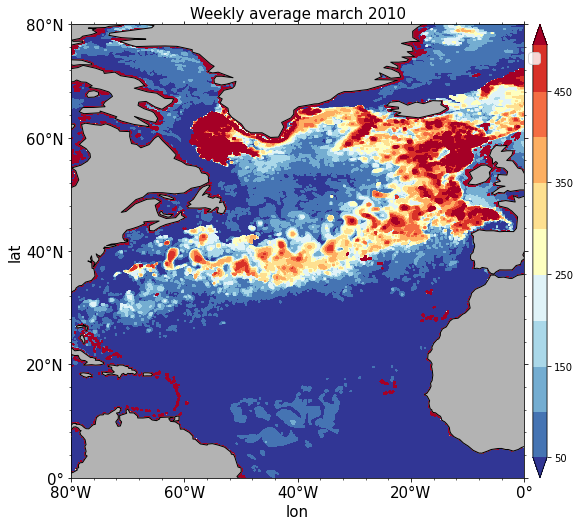

In [9]:
contfs = np.arange(50.,550.,50.)
clim = [contfs.min(), contfs.max()]
 
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=1, fig_size_fac=4, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
#r2b8_inter = pyic.interp_to_rectgrid_xr(r2b8.mlotst.isel(time=tt), fpath_ckdtree=fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(mldx.lon, mldx.lat, mldx, ax=ax, cax=cax, clim = clim, contfs=contfs, transform=ccrs_proj, rasterized=False)
ax.set_title(f'Weekly average march 2010', fontsize=15)
ax.set_xlabel('lon', fontsize=15)
ax.set_ylabel('lat', fontsize=15)

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)
    plt.legend(fontsize=15)
    ax.tick_params(labelsize=15)

plt.savefig(f'../images/eval_ri/mld_week.png', dpi=150, format='png', bbox_inches='tight')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


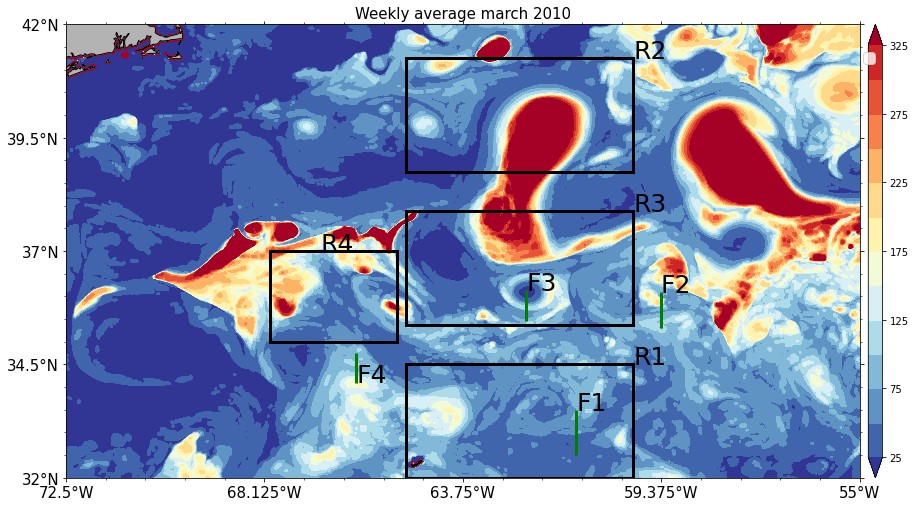

In [24]:
contfs = np.arange(25.,350.,25.)
clim = [contfs.min(), contfs.max()]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])

hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(mldx.lon, mldx.lat, mldx, ax=ax, cax=cax, clim = clim, contfs=contfs, transform=ccrs_proj, rasterized=False)
add_rect()

ax.set_title(f'Weekly average march 2010', fontsize=15)
# ax.set_xlabel('lon', fontsize=15)
# ax.set_ylabel('lat', fontsize=15)

lon_reg_large = [-72.5, -55]
lat_reg_large = [32, 42]

lon_reg = lon_reg_large
lat_reg = lat_reg_large

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)
    plt.legend(fontsize=15)
    ax.tick_params(labelsize=15)

plt.savefig(f'../images/eval_ri/mld_week_select.png', dpi=150, format='png', bbox_inches='tight')



In [12]:
(lat_reg[1]-lat_reg[0])

10

In [13]:
(lon_reg[1]-lon_reg[0])

17.5

(350.0, 0.0)

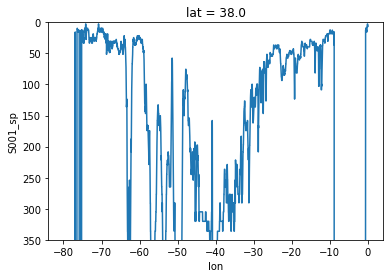

In [30]:
mldx.sel(lat=38, method='nearest').plot()
plt.ylim(350,0)

In [31]:
data_t_mean      = pyic.interp_to_rectgrid_xr(t_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

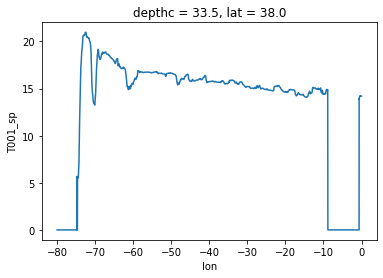

In [35]:
data_t_mean.isel(depthc=10).sel(lat=38, method='nearest').T001_sp.plot()

In [33]:
data_t_mean

<xarray.Dataset>
Dimensions:  (depthc: 112, lat: 4000, lon: 4000)
Coordinates:
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
  * lat      (lat) float64 0.02 0.04 0.06 0.08 0.1 ... 79.94 79.96 79.98 80.0
  * lon      (lon) float64 -80.0 -79.98 -79.96 -79.94 ... -0.06 -0.04 -0.02
Data variables:
    T001_sp  (depthc, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Conclusion
fast way to calculate mld gives expected results, however values close to land seem to be out of limits. 

In [20]:
import matplotlib.patches as patches

In [21]:
def draw_rect(lat, lon, color):
    height = lat[1] - lat[0]
    width = lon[1] - lon[0]
    right = lon[0] + width
    top = lat[0] + height
    rect = patches.Rectangle((lon[0], lat[0]), width, height, linewidth=3, edgecolor=color, facecolor='none')
    return  rect, right, top

In [22]:
def add_rect():
    #boxes
    lon_reg_R1 = [-65, -60]
    lat_reg_R1 = [32, 34.5]
    lon_reg_R2 = [-65, -60]
    lat_reg_R2 = [38.75, 41.25]
    lon_reg_R3 = [-65, -60]
    lat_reg_R3 = [35.375, 37.875]
    lon_reg_R4 = [-68, -65.2]
    lat_reg_R4 = [35, 37]
    #fronts
    lon_f1 = -61.25
    lat_f1 =  32.5, 33.5
    
    lon_f2 = -59.39
    lat_f2 =  35.3, 36.1
    
    lon_f3 = -62.35
    lat_f3 =  35.45, 36.15
    
    lon_f4 = -66.1
    lat_f4 =  34.1, 34.75
    fs=25

    ax.vlines(lon_f1, lat_f1[0], lat_f1[1], color='g', linewidth=3)
    ax.text(lon_f1, lat_f1[1], f'F1', fontsize=fs)

    ax.vlines(lon_f2, lat_f2[0], lat_f2[1], color='g', linewidth=3)
    ax.text(lon_f2, lat_f2[1], f'F2', fontsize=fs)

    ax.vlines(lon_f3, lat_f3[0], lat_f3[1], color='g', linewidth=3)
    ax.text(lon_f3, lat_f3[1], f'F3', fontsize=fs)

    ax.vlines(lon_f4, lat_f4[0], lat_f4[1], color='g', linewidth=3)
    ax.text(lon_f4, lat_f4[0], f'F4', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R1, lon_reg_R1,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R1', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R2, lon_reg_R2,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R2', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R3, lon_reg_R3,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R3', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R4, lon_reg_R4,  color='black')
    ax.add_patch(rect)
    ax.text(right-1.7, top, f'R4', fontsize=fs)